In [1]:
import pyomo.environ as pyo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
world = gpd.read_file("ne_110m_admin_0_countries.zip")
world = world[["SOVEREIGNT","ISO_A2_EH","geometry"]]

In [3]:
input_data = pd.read_excel("Inputdata.xlsx", index_col="Land", keep_default_na=False)

for i in input_data.index: print(i)

## Solver

In [4]:
solver = pyo.SolverFactory('gurobi') 

## Model

In [5]:
model = pyo.ConcreteModel()
#model = pyo.AbstractModel()

## Länder als itterable

input_data.index

In [6]:
model.country = input_data.index

## Parameter

In [7]:
# Parameter in Model importieren
model.h2_price =  pyo.Param(model.country, initialize=input_data["H2 Herstellungspreis"].to_dict())
model.h2_pipeline =  pyo.Param(model.country, initialize=input_data["H2 Pipeline Preis"].to_dict())
model.h2_ship =  pyo.Param(model.country, initialize=input_data["H2 Schiff Preis"].to_dict())
model.h2_limit = pyo.Param(model.country, initialize=input_data["H2 Export Limit"].to_dict())

model.nh3_price =  pyo.Param(model.country, initialize=input_data["NH3 Herstellungspreis"].to_dict())
model.nh3_pipeline =  pyo.Param(model.country, initialize=input_data["NH3 Pipeline Preis"].to_dict())
model.nh3_ship =  pyo.Param(model.country, initialize=input_data["NH3 Schiff Preis"].to_dict())
model.nh3_limit = pyo.Param(model.country, initialize=input_data["NH3 Export Limit"].to_dict())

model.ch3oh_price =  pyo.Param(model.country, initialize=input_data["CH3OH Herstellungspreis"].to_dict())
model.ch3oh_pipeline =  pyo.Param(model.country, initialize=input_data["CH3OH Pipeline Preis"].to_dict())
model.ch3oh_ship =  pyo.Param(model.country, initialize=input_data["CH3OH Schiff Preis"].to_dict())
model.ch3oh_limit = pyo.Param(model.country, initialize=input_data["CH3OH Export Limit"].to_dict())

model.h2_price.pprint()

## Variablen

In [8]:
# Variablen definieren
model.h2_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.h2_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

model.nh3_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.nh3_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

model.ch3oh_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.ch3oh_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

sum(model.h2_amount_pipeline[i] for i in model.country) + sum(model.h2_ship[i] for i in model.country)

imported_h2 = sum(model.h2_amount_pipeline[i] for i in model.country) + sum(model.h2_amount_ship[i] for i in model.country)
imported_nh3 = sum(model.nh3_amount_pipeline[i] for i in model.country) + sum(model.nh3_amount_ship[i] for i in model.country)
imported_ch3oh = sum(model.ch3oh_amount_pipeline[i] for i in model.country) + sum(model.ch3oh_amount_ship[i] for i in model.country)

In [9]:
model.h2_amount_to_nh3 = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.h2_amount_to_ch3oh = pyo.Var(model.country, domain = pyo.NonNegativeReals)

model.pprint()

## Zielfunktion

# Umtauschbarkeit von H2 NH3 CH3OH

In [10]:
h2_to_nh3_eff = 0.7
h2_to_ch3oh_eff = 0.6

# Zielfunktion
obj_expr = sum(model.h2_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_ship[i]*model.h2_amount_ship[i] + model.h2_price[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) +
               model.nh3_pipeline[i]*model.nh3_amount_pipeline[i] + model.nh3_ship[i]*model.nh3_amount_ship[i] + model.nh3_price[i]*(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]) +
               model.ch3oh_pipeline[i]*model.ch3oh_amount_pipeline[i] + model.ch3oh_ship[i]*model.ch3oh_amount_ship[i] + model.ch3oh_price[i]*(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]) for i in model.country)
model.obj = pyo.Objective(sense=pyo.minimize, expr=obj_expr)

# Zielfunktion alt
obj_expr = sum(model.h2_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_ship[i]*model.h2_amount_ship[i] + model.h2_price[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) +
               model.nh3_pipeline[i]*model.nh3_amount_pipeline[i] + model.nh3_ship[i]*model.nh3_amount_ship[i] + model.nh3_price[i]*(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]) +
               model.ch3oh_pipeline[i]*model.ch3oh_amount_pipeline[i] + model.ch3oh_ship[i]*model.ch3oh_amount_ship[i] + model.ch3oh_price[i]*(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i])
               for i in model.country) 
model.obj = pyo.Objective(sense=pyo.minimize, expr=obj_expr)

# hier kann noch ausgeklammert werden

In [11]:
# Zielfunktion neu
obj_expr = sum(
        # Tranportkosten * Menge je Tranportoption + Herstellungspreis * Gesamtmenge
          model.h2_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_ship[i]*model.h2_amount_ship[i] + model.h2_price[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i])
        # Tranportkosten * Menge je Tranportoption + Herstellungspreis * Gesamtmenge
        + model.nh3_pipeline[i]*model.nh3_amount_pipeline[i] + model.nh3_ship[i]*model.nh3_amount_ship[i] + model.nh3_price[i]*(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i])
        # Umwandlung von Wasserstoff zu Chemikalie
        + model.h2_amount_to_nh3[i] * (model.h2_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_ship[i]*model.h2_amount_ship[i] + model.h2_price[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i]))
        # Tranportkosten * Menge je Tranportoption + Herstellungspreis * Gesamtmenge                             
        + model.ch3oh_pipeline[i]*model.ch3oh_amount_pipeline[i] + model.ch3oh_ship[i]*model.ch3oh_amount_ship[i] + model.ch3oh_price[i]*(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i])
        # Umwandlung von Wasserstoff zu Chemikalie
        + model.h2_amount_to_ch3oh[i] * (model.h2_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_ship[i]*model.h2_amount_ship[i] + model.h2_price[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i]))
        for i in model.country) 
model.obj = pyo.Objective(sense=pyo.minimize, expr=obj_expr)

# müssen noch gemacht werden

## Nebenbedingungen

In [12]:
# Bedarfsdeckung
model.demand_constraints = pyo.ConstraintList()

con_demand_h2_lhs = sum(model.h2_amount_pipeline[i] + model.h2_amount_ship[i] for i in model.country)  
con_demand_h2_rhs = 1000000
model.demand_constraints.add(con_demand_h2_lhs >= con_demand_h2_rhs)

con_demand_nh3_lhs = sum(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i] + h2_to_nh3_eff*model.h2_amount_to_nh3[i] * (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) for i in model.country)
con_demand_nh3_rhs = 1000000
model.demand_constraints.add(con_demand_nh3_lhs >= con_demand_nh3_rhs)

con_demand_ch3oh_lhs = sum(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i] + h2_to_ch3oh_eff*model.h2_amount_to_ch3oh[i] * (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) for i in model.country)
con_demand_ch3oh_rhs = 1000000
model.demand_constraints.add(con_demand_ch3oh_lhs >= con_demand_ch3oh_rhs)

# Exportlimits
model.export_constraints = pyo.ConstraintList()

for i in model.country:
    con_export_h2_lhs = (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) * (1 + model.h2_amount_to_nh3[i] + model.h2_amount_to_ch3oh[i])
    con_export_h2_rhs = model.h2_limit[i]
    model.export_constraints.add(con_export_h2_lhs <= con_export_h2_rhs)
    model.export_constraints.add(0 <= con_export_h2_lhs)
    
    con_export_nh3_lhs = model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]
    con_export_nh3_rhs = model.nh3_limit[i]
    model.export_constraints.add(con_export_nh3_lhs <= con_export_nh3_rhs)
    model.export_constraints.add(0 <= con_export_nh3_lhs)
    
    con_export_ch3oh_lhs = model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]
    con_export_ch3oh_rhs = model.ch3oh_limit[i]
    model.export_constraints.add(con_export_ch3oh_lhs <= con_export_h2_rhs)
    model.export_constraints.add(0 <= con_export_ch3oh_lhs)



model.pprint()

In [13]:
# Create a model instance and optimize
instance = model.create_instance()

solver.options['NonConvex'] = 2
results = solver.solve(instance)
#instance.display()

instance.display()

In [14]:
# save model results to dicts
opt_h2_amount_pipeline = {x:instance.h2_amount_pipeline[x].value for x in instance.country}
opt_h2_amount_ship = {x:instance.h2_amount_ship[x].value for x in instance.country}

opt_nh3_amount_pipeline = {x:instance.nh3_amount_pipeline[x].value for x in instance.country}
opt_nh3_amount_ship = {x:instance.nh3_amount_ship[x].value for x in instance.country}

opt_ch3oh_amount_pipeline = {x:instance.ch3oh_amount_pipeline[x].value for x in instance.country}
opt_ch3oh_amount_ship = {x:instance.ch3oh_amount_ship[x].value for x in instance.country}

In [15]:
opt_nh3_amount_ship.values()

dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5270.444406258586, 0.0, 0.0, 0.0, 0.0, 11988.374170125537, 0.0, 100258.50653946456, 0.0, 0.0, 0.0, 0.0, 0.0, 305605.6055591095, 0.0, 118173.74695492536, 0.0, 0.0, 231051.19436475218, 0.0, 0.0, 0.0, 8367.388522881405, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27400.623422332217, 7778.578054138736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128155.74408932282, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22973.740426713597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

fig, ax = plt.subplots(2,3, sharey=True, figsize = (16,9))

ax[0,0].set_title("H2 Schiff")
sns.barplot(x=list(opt_h2_amount_ship.keys()), y = list(opt_h2_amount_ship.values()), ax = ax[0,0])
ax[1,0].set_title("H2 Pipeline")
sns.barplot(x=list(opt_h2_amount_pipeline.keys()), y = list(opt_h2_amount_pipeline.values()), ax = ax[1, 0])

ax[0,1].set_title("NH3 Schiff")
sns.barplot(x=list(opt_nh3_amount_ship.keys()), y = list(opt_nh3_amount_ship.values()), ax = ax[0,1])
ax[1,1].set_title("NH3 Pipeline")
sns.barplot(x=list(opt_nh3_amount_pipeline.keys()), y = list(opt_nh3_amount_pipeline.values()), ax = ax[1, 1])

ax[0,2].set_title("CH3OH Schiff")
sns.barplot(x=list(opt_ch3oh_amount_ship.keys()), y = list(opt_ch3oh_amount_ship.values()), ax = ax[0,2])
ax[1,2].set_title("CH3OH Pipeline")
sns.barplot(x=list(opt_ch3oh_amount_pipeline.keys()), y = list(opt_ch3oh_amount_pipeline.values()), ax = ax[1, 2])


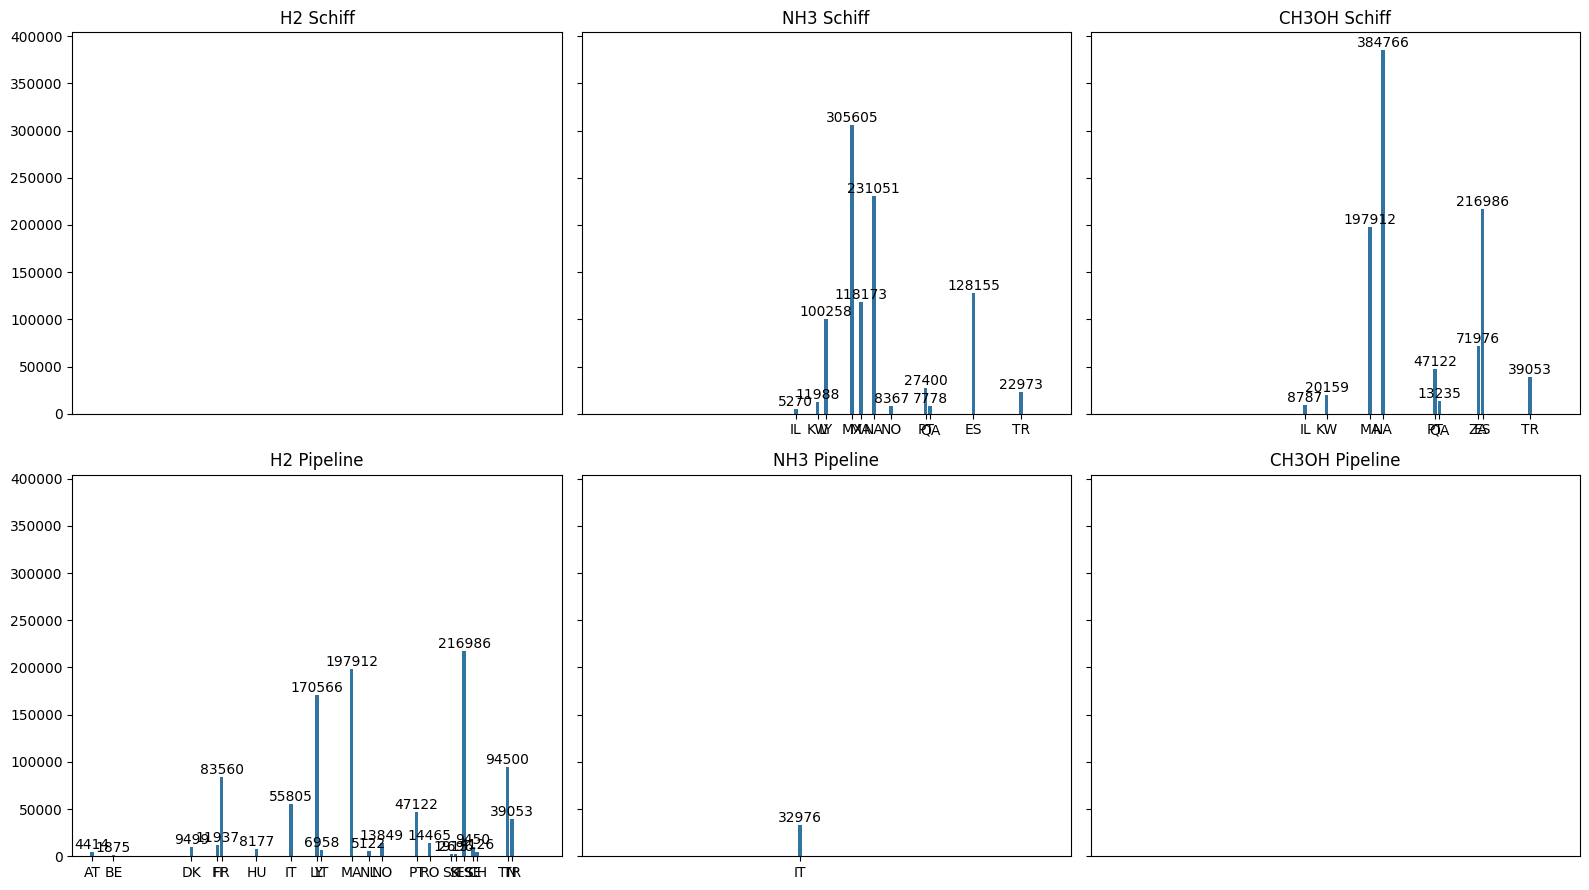

In [16]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(16, 9))

def add_conditional_ticklabels(ax, x, y):
    valid_x = [x_val for x_val, y_val in zip(x, y) if y_val > 0]
    valid_idx = [i for i, y_val in enumerate(y) if y_val > 0]
    
    ax.set_xticks(valid_idx)
    ax.set_xticklabels(valid_x)
    
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                '%d' % int(height),
                ha='center',
                va='bottom'
            )

# H2
ax[0, 0].set_title("H2 Schiff")
sns.barplot(x=list(opt_h2_amount_ship.keys()), y=list(opt_h2_amount_ship.values()), ax=ax[0, 0])
ax[1, 0].set_title("H2 Pipeline")
sns.barplot(x=list(opt_h2_amount_pipeline.keys()), y=list(opt_h2_amount_pipeline.values()), ax=ax[1, 0])
add_conditional_ticklabels(ax[0, 0], list(opt_h2_amount_ship.keys()), list(opt_h2_amount_ship.values()))
add_conditional_ticklabels(ax[1, 0], list(opt_h2_amount_pipeline.keys()), list(opt_h2_amount_pipeline.values()))

# NH3
ax[0, 1].set_title("NH3 Schiff")
sns.barplot(x=list(opt_nh3_amount_ship.keys()), y=list(opt_nh3_amount_ship.values()), ax=ax[0, 1])
ax[1, 1].set_title("NH3 Pipeline")
sns.barplot(x=list(opt_nh3_amount_pipeline.keys()), y=list(opt_nh3_amount_pipeline.values()), ax=ax[1, 1])
add_conditional_ticklabels(ax[0, 1], list(opt_nh3_amount_ship.keys()), list(opt_nh3_amount_ship.values()))
add_conditional_ticklabels(ax[1, 1], list(opt_nh3_amount_pipeline.keys()), list(opt_nh3_amount_pipeline.values()))

# CH3OH
ax[0, 2].set_title("CH3OH Schiff")
sns.barplot(x=list(opt_ch3oh_amount_ship.keys()), y=list(opt_ch3oh_amount_ship.values()), ax=ax[0, 2])
ax[1, 2].set_title("CH3OH Pipeline")
sns.barplot(x=list(opt_ch3oh_amount_pipeline.keys()), y=list(opt_ch3oh_amount_pipeline.values()), ax=ax[1, 2])
add_conditional_ticklabels(ax[0, 2], list(opt_ch3oh_amount_ship.keys()), list(opt_ch3oh_amount_ship.values()))
add_conditional_ticklabels(ax[1, 2], list(opt_ch3oh_amount_pipeline.keys()), list(opt_ch3oh_amount_pipeline.values()))

plt.tight_layout()
plt.show()


opt_h2_amount_pipeline

In [17]:
#test = pd.DataFrame.from_dict(opt_h2_amount_pipeline, orient='index', columns = ["H2 Pipeline"])
opt_h2_amount_pipeline_df = pd.DataFrame.from_dict(opt_h2_amount_pipeline, orient='index', columns = ["H2 Pipeline"])
opt_h2_amount_ship_df = pd.DataFrame.from_dict(opt_h2_amount_ship, orient='index', columns = ["H2 Schiff"])

opt_nh3_amount_pipeline_df = pd.DataFrame.from_dict(opt_nh3_amount_pipeline, orient='index', columns = ["NH3 Pipeline"])
opt_nh3_amount_ship_df = pd.DataFrame.from_dict(opt_nh3_amount_ship, orient='index', columns = ["NH3 Schiff"])

opt_ch3oh_amount_pipeline_df = pd.DataFrame.from_dict(opt_ch3oh_amount_pipeline, orient='index', columns = ["CH3OH Pipeline"])
opt_ch3oh_amount_ship_df = pd.DataFrame.from_dict(opt_ch3oh_amount_ship, orient='index', columns = ["CH3OH Schiff"])

In [18]:
#world_opt = world.merge(test, left_on="ISO_A2", right_index=True)
world_opt = world.copy()
opt_dfs = [opt_h2_amount_pipeline_df, opt_h2_amount_ship_df, opt_nh3_amount_pipeline_df, opt_nh3_amount_ship_df, opt_ch3oh_amount_pipeline_df, opt_ch3oh_amount_ship_df]
for df in opt_dfs:
    world_opt = world_opt.merge(df, how = "left",left_on="ISO_A2_EH", right_index=True)
world_opt = world_opt.set_index("ISO_A2_EH")
world_opt["H2 gesamt"] = world_opt["H2 Pipeline"] + world_opt["H2 Schiff"]
world_opt["NH3 gesamt"] = world_opt["NH3 Pipeline"] + world_opt["NH3 Schiff"]
world_opt["CH3OH gesamt"] = world_opt["CH3OH Pipeline"] + world_opt["CH3OH Schiff"]

world_opt["Gesamter Import"] = world_opt["H2 gesamt"] + world_opt["NH3 gesamt"] + world_opt["CH3OH gesamt"]

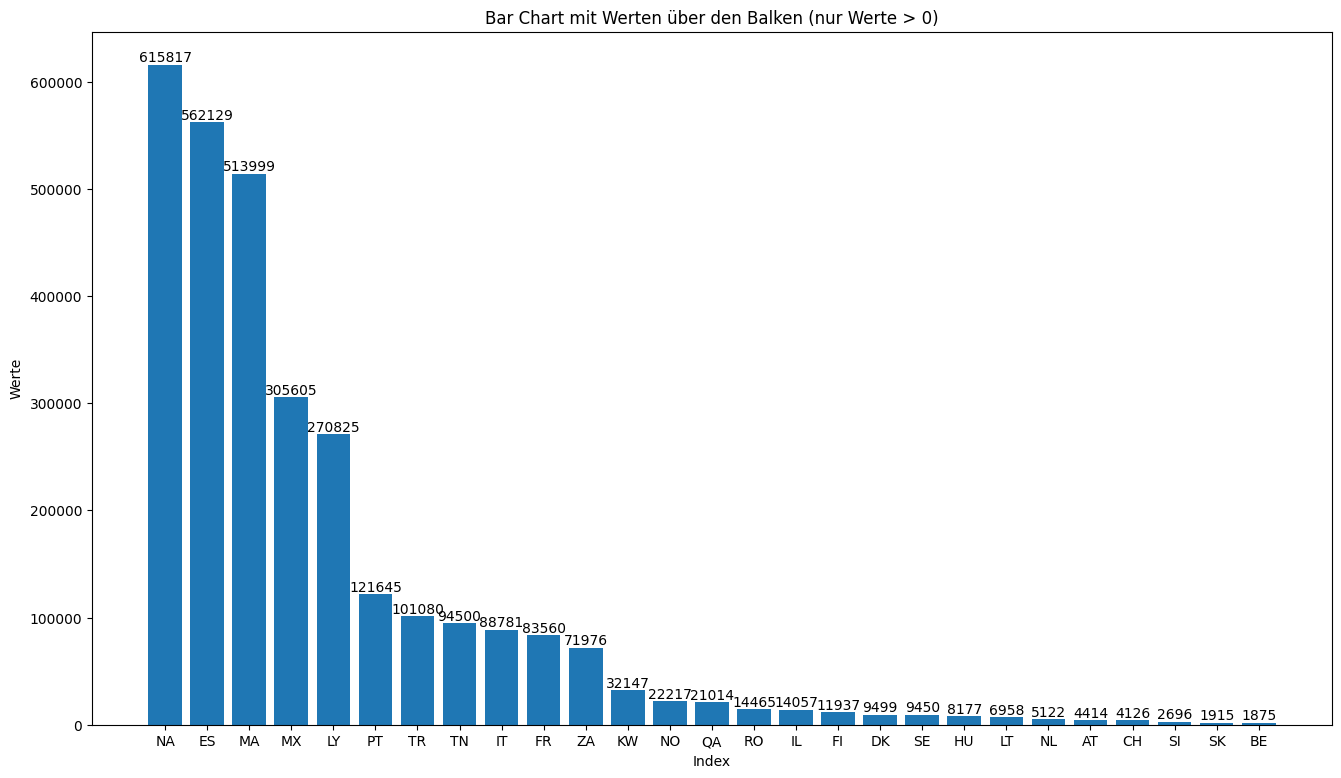

In [23]:
plt.figure(figsize=(16, 9))
#df_sorted = df[df['Werte'] > 0].sort_values(by='Werte', ascending=False)
positive_values = world_opt[world_opt["Gesamter Import"] > 0].sort_values(by="Gesamter Import",ascending=False)
plt.bar(positive_values.index, positive_values['Gesamter Import'])
for index, value in zip(positive_values.index, positive_values['Gesamter Import']):
    plt.text(index, value + 0.1, str(int(value)), ha='center', va='bottom')

plt.xlabel('Index')
plt.ylabel('Werte')
plt.title('Bar Chart mit Werten über den Balken (nur Werte > 0)')
plt.show()


Text(0.5, 1.0, 'Gesamter Import')

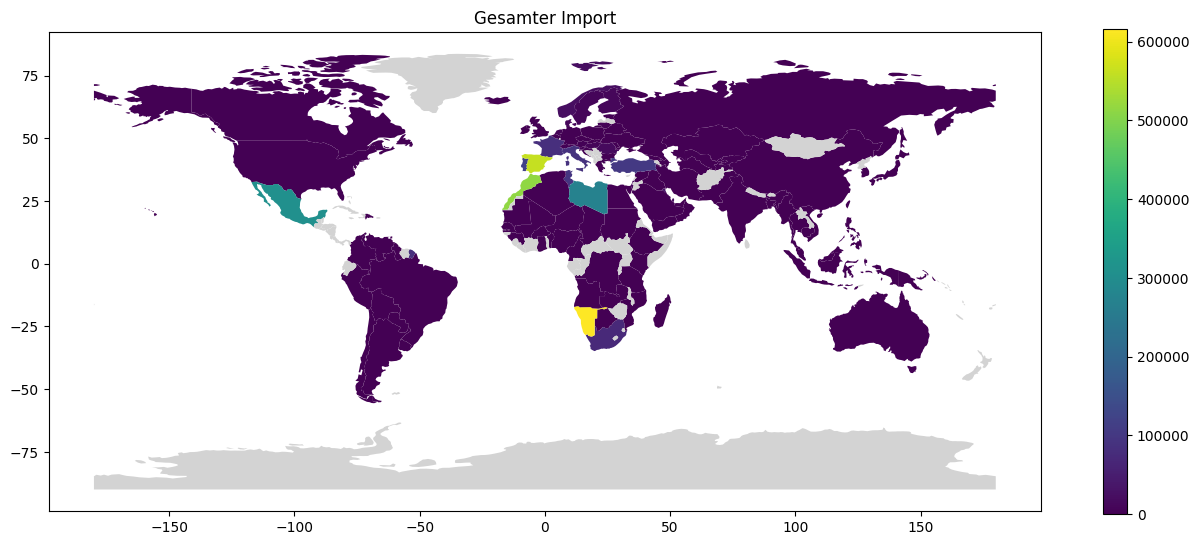

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
world_opt.plot(column='Gesamter Import', cmap='viridis', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, legend_kwds={'shrink': 0.7})
ax.set_title("Gesamter Import")

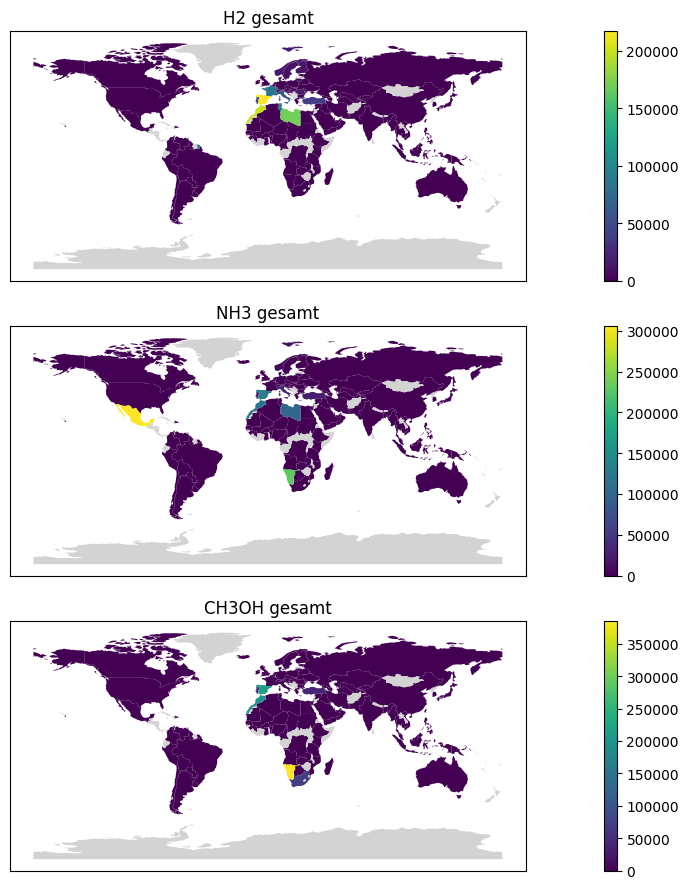

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9))

world_opt.plot(column='H2 gesamt', cmap='viridis', legend=True, ax=ax[0], missing_kwds={'color': 'lightgrey'})
ax[0].set_title("H2 gesamt")
#ax[0].set_xticks([])
#ax[0].set_yticks([])

world_opt.plot(column='NH3 gesamt', cmap='viridis', legend=True, ax=ax[1], missing_kwds={'color': 'lightgrey'})
ax[1].set_title("NH3 gesamt")

world_opt.plot(column='CH3OH gesamt', cmap='viridis', legend=True, ax=ax[2], missing_kwds={'color': 'lightgrey'})
ax[2].set_title("CH3OH gesamt")


# Turn off tick labels
for x in ax:
    x.set_xticks([])
    x.set_yticks([])


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'CH3OH Schiff')

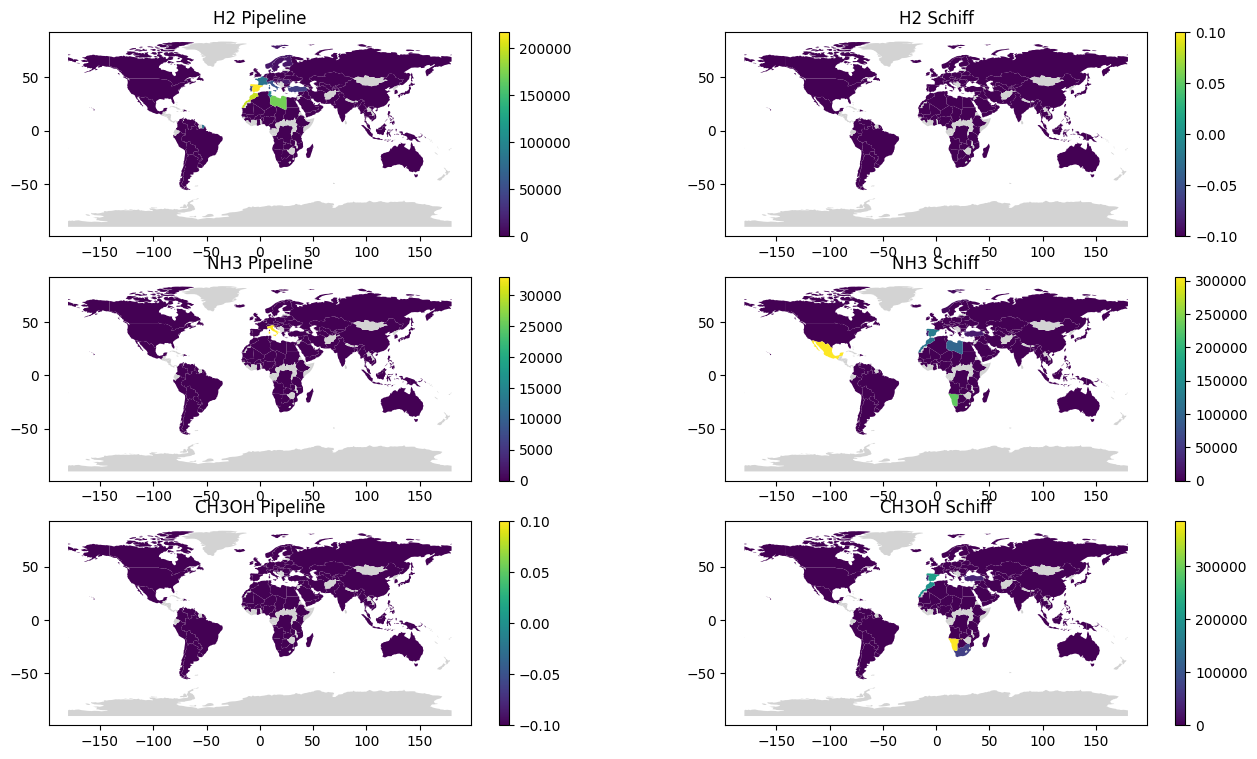

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(16, 9))

world_opt.plot(column='H2 Pipeline', cmap='viridis', legend=True, ax=ax[0,0], missing_kwds={'color': 'lightgrey'})
ax[0, 0].set_title("H2 Pipeline")

world_opt.plot(column='H2 Schiff', cmap='viridis', legend=True, ax=ax[0,1], missing_kwds={'color': 'lightgrey'})
ax[0, 1].set_title("H2 Schiff")

world_opt.plot(column='NH3 Pipeline', cmap='viridis', legend=True, ax=ax[1,0], missing_kwds={'color': 'lightgrey'})
ax[1, 0].set_title("NH3 Pipeline")

world_opt.plot(column='NH3 Schiff', cmap='viridis', legend=True, ax=ax[1,1], missing_kwds={'color': 'lightgrey'})
ax[1, 1].set_title("NH3 Schiff")

world_opt.plot(column='CH3OH Pipeline', cmap='viridis', legend=True, ax=ax[2,0], missing_kwds={'color': 'lightgrey'})
ax[2, 0].set_title("CH3OH Pipeline")

world_opt.plot(column='CH3OH Schiff', cmap='viridis', legend=True, ax=ax[2,1], missing_kwds={'color': 'lightgrey'})
ax[2, 1].set_title("CH3OH Schiff")